## DNN(MLP) 모델을 이용한 자동차 연비 데이터 셋 회귀 분석

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models

In [9]:
print(tf.__version__)

2.2.0-rc3


### Step 1-1. Inptu tensor 와 Target tensor 준비(훈련데이터)
* 자동차 연비 데이터셋 파일 down

In [11]:
auto_mpg_dataset_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
dataset_path = tf.keras.utils.get_file("/content/auto-mpg.data", auto_mpg_dataset_url)
dataset_path

'/content/auto-mpg.data'

*  데이터 셋 파일을 읽어 Dataframe 객체 생성

In [12]:
# 자동차 연비 데이터 셋의 컬럼명
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values='?', comment='\t',
                          sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


### Step 1-2. 입력 데이터의 전처리 
* 데이터 셋 내의 NaN 값 제거

In [14]:
# 데이터 셋 내의 Nan 값 체크
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
# 데이터 셋 내 의 Nan 값 제거
dataset = dataset.dropna()

In [16]:
len(dataset)

392

In [23]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

* 데이터셋 에서 20% 선택하여 test 데이터 셋으로 분할

In [0]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [19]:
print(len(train_dataset))
print(len(test_dataset))

314
78


* 표준화를 통한 Input tensor의 전처리

In [0]:
# 데이터 전처리를 위한 통계정보 생성
train_stats = train_dataset.describe()

In [25]:
train_stats

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,23.310510,5.477707,195.318471,104.869427,2990.251592,15.559236,75.898089,1.573248
std,7.728652,1.699788,104.331589,38.096214,843.898596,2.789230,3.675642,0.800988
min,10.000000,3.000000,68.000000,46.000000,1649.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.500000,76.250000,2256.500000,13.800000,73.000000,1.000000
50%,22.000000,4.000000,151.000000,94.500000,2822.500000,15.500000,76.000000,1.000000
75%,28.950000,8.000000,265.750000,128.000000,3608.000000,17.200000,79.000000,2.000000
max,46.600000,8.000000,455.000000,225.000000,5140.000000,24.800000,82.000000,3.000000


In [26]:
# 정답 데이터(MPG-연비) 제거
train_stats.pop('MPG')

count    314.000000
mean      23.310510
std        7.728652
min       10.000000
25%       17.000000
50%       22.000000
75%       28.950000
max       46.600000
Name: MPG, dtype: float64

In [27]:
train_stats

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,5.477707,195.318471,104.869427,2990.251592,15.559236,75.898089,1.573248
std,1.699788,104.331589,38.096214,843.898596,2.789230,3.675642,0.800988
min,3.000000,68.000000,46.000000,1649.000000,8.000000,70.000000,1.000000
25%,4.000000,105.500000,76.250000,2256.500000,13.800000,73.000000,1.000000
50%,4.000000,151.000000,94.500000,2822.500000,15.500000,76.000000,1.000000
75%,8.000000,265.750000,128.000000,3608.000000,17.200000,79.000000,2.000000
max,8.000000,455.000000,225.000000,5140.000000,24.800000,82.000000,3.000000


In [0]:
# 각 특성 별 통계정보를 가공하기 쉽도록 matrix 전치
train_stats = train_stats.transpose()

In [29]:
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Origin,314.0,1.573248,0.800988,1.0,1.00,1.0,2.00,3.0


In [0]:
# Target tensor 를 위한 연비 값(MPG - Miles Per Gallon) 추출
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [33]:
train_dataset

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
146,4,90.0,75.0,2125.0,14.5,74,1
282,4,140.0,88.0,2890.0,17.3,79,1
69,8,350.0,160.0,4456.0,13.5,72,1
378,4,105.0,63.0,2125.0,14.7,82,1
331,4,97.0,67.0,2145.0,18.0,80,3
...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,1
229,8,400.0,180.0,4220.0,11.1,77,1
150,4,108.0,93.0,2391.0,15.5,74,3
145,4,83.0,61.0,2003.0,19.0,74,3


In [0]:
# Input tensor의 표준화(평균 :0/ 표준편차 :1) 함수 정의
def norm(x):
  normed_data = (x - train_stats['mean']) / train_stats['std']
  return normed_data

In [0]:
# Input tensor 의 특성 정보 표준화 처리 수행
train_dataset = norm(train_dataset)
test_dataset = norm(test_dataset)

In [37]:
train_dataset.describe()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,3.140000e+02,3.140000e+02,3.140000e+02,3.140000e+02,3.140000e+02,3.140000e+02,3.140000e+02
mean,2.093159e-16,1.018294e-16,-1.909301e-17,-9.723291e-17,2.688832e-15,9.561531e-16,-1.806764e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.457657e+00,-1.220325e+00,-1.545283e+00,-1.589352e+00,-2.710152e+00,-1.604642e+00,-7.156763e-01
25%,-8.693480e-01,-8.608943e-01,-7.512407e-01,-8.694784e-01,-6.307245e-01,-7.884578e-01,-7.156763e-01
50%,-8.693480e-01,-4.247848e-01,-2.721905e-01,-1.987817e-01,-2.123729e-02,2.772599e-02,-7.156763e-01
75%,1.483887e+00,6.750739e-01,6.071620e-01,7.320173e-01,5.882500e-01,8.439098e-01,5.327813e-01
max,1.483887e+00,2.489002e+00,3.153347e+00,2.547401e+00,3.313017e+00,1.660094e+00,1.781239e+00


### Step2. DNN(MLP) 모델 디자인

In [0]:
# hidden layer : 2개[64, 32], activation : relu
model = models.Sequential()
model.add(layers.Dense(units=64, activation='relu', input_shape=(len(train_dataset.keys()),)))
model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dense(units=1))

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________


### Step 3. 모델의 학습 정보 설정

In [0]:
# loss : mean square error/ optimizer : rmsprop/ metric : mean absolute error
model.compile(loss='mse',
              optimizer='rmsprop',
              metrics=['mae'])

### Step 4. 모델에 input, target 데이터 연결 후 학습

In [44]:
# batch size : 16, epochs : 100, validation data set percent : 20%
history = model.fit(
    x=train_dataset, y=train_labels,
    batch_size=16,
    epochs=100,
    validation_split=0.2
)

Epoch 1/100
16/16 [==============================] - 0s 12ms/step - loss: 585.2809 - mae: 22.9651 - val_loss: 581.6447 - val_mae: 22.9329
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 542.1143 - mae: 22.0001 - val_loss: 529.9721 - val_mae: 21.8097
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 482.9922 - mae: 20.7992 - val_loss: 463.4747 - val_mae: 20.3311
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 417.0164 - mae: 19.2610 - val_loss: 385.4815 - val_mae: 18.4571
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 42.3094 - mae: 5.1998 - val_loss: 37.8325 - val_mae: 5.0905
Epoch 12/100
16/16 [==============================] - 0s 4ms/step - loss: 36.4189 - mae: 4.8187 - val_loss: 32.9017 - val_mae: 4.7573
Epoch 13/100
16/16 [==============================] - 0s 3ms/step - loss: 31.0893 - mae: 4.4237 - val_loss: 29.1783 - val_mae: 4.4247
Epoch 14/100
16/16 [==============================

### 학습과정의 시각화 및 성능 테스트

In [45]:
hist = pd.DataFrame(history.history)
hist

,loss,mae,val_loss,val_mae
0,585.280945,22.965117,581.644714,22.932943
1,542.114258,22.000093,529.972107,21.809727
2,482.992188,20.799181,463.474701,20.331085
3,417.016449,19.261030,385.481506,18.457090
4,345.490906,17.348322,299.248779,16.129589
...,...,...,...,...
95,6.277800,1.754738,8.912477,2.286916
96,6.105707,1.711276,9.064934,2.331384
97,6.099285,1.731613,9.007498,2.287900
98,6.041389,1.710547,8.887577,2.194067


In [0]:
# 학습과정 시각화를 위한 정보 추출
loss = history.history['loss']
val_loss = history.history['val_loss']

mae = history.history['mae']
val_mae = history.history['val_mae']

In [0]:
# 차트의 x 축을 위한 epoch 정보 생성
epochs = range(1, len(loss)+1)

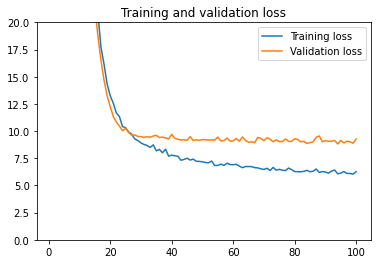

In [48]:
# loss 정보 시각화
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylim([0,20])
plt.legend()

plt.show()

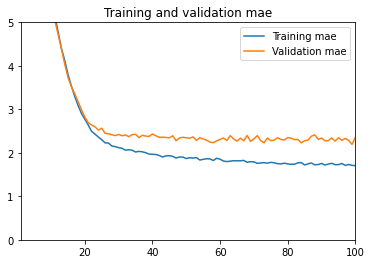

In [49]:
# Mean Absolute Error 정보 시각화
plt.plot(epochs, mae, label='Training mae')
plt.plot(epochs, val_mae, label='Validation mae')
plt.title('Training and validation mae')
plt.xlim([1,100])
plt.ylim([0,5])
plt.legend()

plt.show()

In [51]:
# 테스트 데이터 셋을 통한 성능 측정
test_loss, test_mae = model.evaluate(x=test_dataset, y=test_labels)

3/3 [==============================] - 0s 2ms/step - loss: 6.9180 - mae: 1.9322


In [0]:
# 테스트 데이터 셋의 정답과 모델의 예측값 분석을 위한 모델의 예측값 생성
test_predictions = model.predict(test_dataset).flatten()

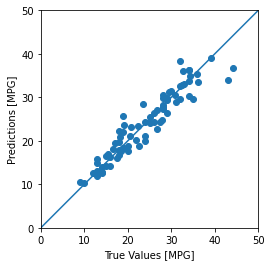

In [54]:
# 테스트 데이터 셋의 정답과 모델의 예측값을 이용한 상관 관계 시각화
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, 50])
plt.ylim([0,50])
_ = plt.plot([-100, 100], [-100, 100])